In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.models.rnn import *
from tensorflow.contrib import rnn
import os

In [2]:
data = 'data/weather_30000.csv'
df = pd.read_csv(data)
df.head()

,UTC_Date,TempM,DewPointM,Humidity,WindSpeedM,VisibilityM,PressureA
0,51:00.0,22.8,12.8,53,11.1,16.1,30.08
1,51:00.0,21.7,13.3,59,7.4,16.1,30.07
2,51:00.0,20.0,13.3,65,16.7,16.1,30.06
3,51:00.0,19.4,13.3,68,9.3,16.1,30.06
4,51:00.0,18.9,13.3,70,5.6,16.1,30.04


In [3]:
#for col in list(df.columns)
cols = list(df.columns)
print cols
#print len(df)
#print len(df.loc[~(df['VisibilityM']==-9999)])

['UTC_Date', 'TempM', 'DewPointM', 'Humidity', 'WindSpeedM', 'VisibilityM', 'PressureA']


In [4]:
def preprocess(df):   
    cols = ['TempM', 'DewPointM', 'Humidity', 'WindSpeedM', 'VisibilityM', 'PressureA']
    df = df[cols]
    for col in cols:
        df = df.loc[~(df[col]==-9999)]
        df = df[~(df.isnull())]
    df = df.reset_index(drop = True)
    return df

In [5]:
df1 = preprocess(df)
df1.describe()

,TempM,DewPointM,Humidity,WindSpeedM,VisibilityM,PressureA
count,27534.000000,27534.000000,27534.000000,27534.000000,27534.000000,27534.00000
mean,12.885694,5.152045,62.560471,8.710776,13.188265,30.02106
std,10.170781,11.057698,19.880571,6.082485,4.789264,0.22912
min,-18.300000,-28.300000,9.000000,0.000000,0.400000,29.02000
25%,4.400000,-3.300000,46.000000,5.600000,11.300000,29.88000
50%,13.900000,6.700000,62.000000,7.400000,16.100000,30.02000
75%,21.700000,14.400000,81.000000,13.000000,16.100000,30.17000
max,35.600000,25.600000,100.000000,137.000000,16.100000,30.82000


In [23]:
# scaler = MinMaxScaler((0,1))
# def get_batch(df,batch_size = 128, T = 16, step = 0): 
#     t = step*batch_size
#     X_batch = df.iloc[t:t+T].values
#     X_batch = scaler.fit_transform(X_batch)
#     X_batch = np.expand_dims(X_batch,0)
#     y_batch = df['TempM'].iloc[t:t+T]
#     y_batch = np.reshape(y_batch.values,[1,T])
#     label = df['TempM'].iloc[t+T+1]
#     labels = []
#     labels.append(label)
#     for i in range(1,batch_size):
#         t+=1
#         dat_x = df.iloc[t:t+T].values
#         dat_x = scaler.fit_transform(dat_x)
#         dat_x = np.expand_dims(dat_x,0)
#         X_batch = np.concatenate([X_batch,dat_x], axis = 0)
        
#         dat_y = df['TempM'].iloc[t:t+T]
#         dat_y = np.reshape(dat_y.values,[1,T])
#         y_batch = np.concatenate([y_batch,dat_y],axis = 0)
#         labels.append(df['TempM'].iloc[t+T+1])
    
#     return X_batch,y_batch,np.array(labels)

In [6]:
scaler = MinMaxScaler((0,1))
def get_batch(df,batch_size = 128, T = 16, input_dim = 6, step = 0, train = True):
    
    t = step*batch_size
    X_batch = np.empty(shape = [batch_size,T,input_dim])
    y_batch = np.empty(shape = [batch_size,T])
    labels = np.empty(shape = [batch_size])
    
    for i in range(batch_size):
        X_batch[i,:] = scaler.fit_transform(df.iloc[t:t+T].values)
        y_batch[i,:] = df["TempM"].iloc[t:t+T].values
        labels[i] = df["TempM"].iloc[t+T]
        t += 1     
    
    ## shuffle in train, not in test
    if train:
        index = range(batch_size)
        np.random.shuffle(index)
        X_batch = X_batch[index]
        y_batch = y_batch[index]
        labels = labels[index]

    return X_batch,y_batch,labels

In [7]:
class ts_prediction(object):
    
    def __init__(self, input_dim, time_step, n_hidden, d_hidden, batch_size):

        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.d_hidden = d_hidden
        self.o_hidden = 32
        
        self.input_dim = input_dim
        self.time_step = time_step
        
        self.seq_len = tf.placeholder(tf.int32,[None])
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, None, input_dim])
        self.old_loss = tf.placeholder(shape = [],dtype = tf.float32) ## placeholder for loss_1 original loss
        self.input_y = tf.placeholder(dtype = tf.float32,shape = [None,self.time_step])
        self.label = tf.placeholder(dtype = tf.float32)
        
        self.encode_cell = tf.contrib.rnn.LSTMCell(self.n_hidden, forget_bias=1.0, state_is_tuple=True)
        self.decode_cell = tf.contrib.rnn.LSTMCell(self.d_hidden, forget_bias=1.0, state_is_tuple=True)
        self.output_cell = tf.contrib.rnn.LSTMCell(self.o_hidden, forget_bias=1.0, state_is_tuple=True)
        self.loss_1 = tf.constant(0.0)
        self.loss = tf.constant(0.0)
        
            ## ===========  build the model =========== ##
            
            ## ==== encoder ===== ##
        
        out = self.en_RNN(self.input_x) # out[0]: (b*T*2d)
        self.out = out
        out = tf.transpose(out,[0,2,1]) # (b,2d,T)
        with tf.name_scope('encoder') as scope:
            stddev = 1.0/(self.n_hidden*self.time_step)
            Ue = tf.Variable(dtype=tf.float32,
                             initial_value = tf.truncated_normal(shape = [self.time_step,self.time_step], 
                                                                 mean = 0.0, stddev = stddev),name = 'Ue')
        var = tf.tile(tf.expand_dims(Ue,0),[self.batch_size,1,1]) #(b,T,T)
        
        batch_mul = tf.matmul(var,self.input_x) # (b*T*T)*(b*T*d) = (b,T,d)
        self.out = batch_mul
        e_list = []

        for k in range(self.input_dim):
            series_k = tf.reshape(batch_mul[:,:,k],[self.batch_size,self.time_step,1]) #(b,T,1)
            e_k = self.attention(out,series_k, scope = 'encoder')
            e_list.append(e_k)
        e_list = tf.concat(e_list,axis = 1)
        soft_attention = tf.nn.softmax(e_list,dim = 1)
        input_attention = tf.multiply(self.input_x,tf.transpose(soft_attention,[0,2,1])) #(b,T,d)
        
        with tf.variable_scope('fw_lstm') as scope:
            tf.get_variable_scope().reuse_variables()
            h,_ = tf.nn.dynamic_rnn(self.encode_cell, input_attention, self.seq_len, dtype = tf.float32)
        # h: (b,T,d)
        
            # ===== decoder ===== ## 
        d, dec_out = self.de_RNN(h) ## d: (b,T,q); dec_out:(b,T,2q)
        self.out = d
        dec_out = tf.transpose(dec_out,[0,2,1])
        with tf.name_scope('decoder') as scope:
            stddev = 1.0/(self.d_hidden*self.time_step)
            Ud = tf.Variable(dtype=tf.float32,
                             initial_value = tf.truncated_normal(shape = [self.n_hidden,self.n_hidden], 
                                                                 mean = 0.0, stddev = stddev),name = 'Ud')
        de_var = tf.tile(tf.expand_dims(Ud,0),[self.batch_size,1,1]) # (b,d,d)
        batch_mul_de = tf.matmul(h,de_var) #(b, T, d)
        batch_mul_de = tf.transpose(batch_mul_de,[0,2,1])
        e_de_list = []
        for t in range(self.time_step):
            series_t = tf.reshape(batch_mul_de[:,:,t],[self.batch_size,self.n_hidden,1])
            e_t = self.de_attention(dec_out,series_t, scope = 'decoder')
            e_de_list.append(e_t)
        e_de_list = tf.concat(e_de_list,axis = 1) # b,T,T
        de_soft_attention = tf.nn.softmax(e_de_list,dim = 1)
        #self.out = de_soft_attention
        
            # ===== context c_t ===== ##
        c_list = []
        for t in range(self.time_step):
            Beta_t = tf.expand_dims(de_soft_attention[:,:,0],-1)
            weighted = tf.reduce_sum(tf.multiply(Beta_t,h),1)
            c_list.append(tf.expand_dims(weighted,1))
        c_t = tf.concat(c_list,axis = 1) ## (b,T,d)
        self.out = c_t
        c_t_hat = tf.concat([c_t,tf.expand_dims(self.input_y,-1)],axis = 2) # b,T,(d+1), where +1 for concatenation
        
            # ===== y_hat ===== ##
        with tf.variable_scope('temporal'):
            mean = 0.0
            stddev = 1.0/(self.n_hidden*self.time_step)
            W_hat = tf.get_variable(name = 'W_hat',shape = [self.n_hidden+1,1],dtype = tf.float32,
                                    initializer=tf.truncated_normal_initializer(mean,stddev)) 
        
        W_o = tf.tile(tf.expand_dims(W_hat,0),[self.batch_size,1,1])
        y_hat = tf.matmul(c_t_hat,W_o) ## b,T,1
        
            ## ==== final step ==== ##
        d_y_concat = tf.concat([d,y_hat],axis = 2) ## b,T,q+1
        with tf.variable_scope('out_lstm') as scope:
            d_final,_ = tf.nn.dynamic_rnn(self.output_cell, d_y_concat, self.seq_len, dtype = tf.float32) # b,T,o_hidden
            
            ## ==== output y_T ==== ##
        ## only concat the last state d_T and c_T
        d_c_concat = tf.concat([d_final[:,-1,:],c_t[:,-1,:]],axis = 1) #b,o_hidden+q
        d_c_concat = tf.expand_dims(d_c_concat,-1) # b,d+q,1
        
        with tf.variable_scope('predict'):
            mean = 0.0
            stddev = 1.0/(self.n_hidden*self.time_step)
            Wy = tf.get_variable(name = 'Wy',shape = [self.o_hidden,self.o_hidden+self.n_hidden],dtype = tf.float32,
                                 initializer=tf.truncated_normal_initializer(mean,stddev)) 
            Vy = tf.get_variable(name = 'Vy',shape = [self.o_hidden],dtype = tf.float32,
                                 initializer=tf.truncated_normal_initializer(mean,stddev)) 
            bw = tf.get_variable(name = 'bw',shape = [self.o_hidden],dtype = tf.float32,
                                initializer = tf.constant_initializer(0.1))
        W_y = tf.tile(tf.expand_dims(Wy,0),[self.batch_size,1,1]) # b,q,q+d
        b_w = tf.expand_dims(tf.tile(tf.expand_dims(bw,0),[self.batch_size,1]),-1) #b,q -> b,q,1
        V_y = tf.tile(tf.expand_dims(Vy,0),[self.batch_size,1]) #b,q
        V_y = tf.expand_dims(V_y,1) #b,1,q
        self.y_predict = tf.squeeze(tf.matmul(V_y,tf.matmul(W_y,d_c_concat)+b_w)) #(b,1,q) * (b,q,1) -> squeeze -> (b,)
        self.loss_1 += tf.reduce_mean(tf.square(self.label - self.y_predict))
        ### Adversarial Training
        self.adversarial_gradient = tf.gradients(self.loss_1,self.input_x)
        ###
        self.loss = self.loss_1 + self.old_loss
        self.params = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(1e-4)
        #self.train_op = optimizer.minimize(self.loss)
        grad_var = optimizer.compute_gradients(loss = self.loss, var_list = self.params, aggregation_method = 2)
        self.train_op = optimizer.apply_gradients(grad_var)
        
        
    def en_RNN(self,input_x):
        
        with tf.variable_scope('fw_lstm') as scope:
            cell = self.encode_cell  ## this step don't create variable 
            out, states = tf.nn.dynamic_rnn(cell, input_x, self.seq_len, dtype = tf.float32) ## this step does create variables
            
        tmp = tf.tile(states[1],[1,self.time_step])
        tmp = tf.reshape(tmp,[self.batch_size, self.time_step, self.n_hidden])
        
        concat = tf.concat([out,tmp],axis = 2)
        return concat ## shape shoule be (b,T,2*n_hidden)
    
    def de_RNN(self,h):
        
        with tf.variable_scope('dec_lstm') as scope:
            cell = self.decode_cell
            d,s = tf.nn.dynamic_rnn(cell, h, self.seq_len, dtype = tf.float32)
        tmp = tf.tile(s[1],[1,self.time_step])
        tmp = tf.reshape(tmp,[self.batch_size, self.time_step, self.d_hidden])
        concat = tf.concat([d,tmp],axis = 2)
        return d,concat
        
    def attention(self, out, series_k, scope = None):
   
        with tf.variable_scope('encoder') as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                We = tf.get_variable(name = 'We', dtype=tf.float32,shape = [self.time_step, 2*self.n_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Ve = tf.get_variable(name = 'Ve',dtype=tf.float32,shape = [1,self.time_step],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                We = tf.get_variable('We')
                Ve = tf.get_variable('Ve')       
        W_e = tf.tile(tf.expand_dims(We,0),[self.batch_size,1,1])  # b*T*2d
        brcast = tf.nn.tanh(tf.matmul(W_e,out) + series_k) # b,T,T + b,T,1 = b, T, T
        V_e = tf.tile(tf.expand_dims(Ve,0),[self.batch_size,1,1]) # b,1,T
        
        return tf.matmul(V_e,brcast) # b,1,T
    
    def de_attention(self,out,series_k,scope = None):
        
        with tf.variable_scope('decoder') as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.d_hidden*self.time_step)
                Wd = tf.get_variable(name = 'Wd', dtype=tf.float32,shape = [self.n_hidden, 2*self.d_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Vd = tf.get_variable(name = 'Vd',dtype=tf.float32,shape = [1,self.n_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                Wd = tf.get_variable('Wd')
                Vd = tf.get_variable('Vd') 
        W_d = tf.tile(tf.expand_dims(Wd,0),[self.batch_size,1,1])
        brcast = tf.nn.tanh(tf.matmul(W_d,out) + series_k) # b,d,2q * b,2q*T = b,d,T
        #return brcast
        V_d = tf.tile(tf.expand_dims(Vd,0),[self.batch_size,1,1]) # b,1,d
        
        return tf.matmul(V_d,brcast) # b,1,d * b,d,T = b,1,T
    
    def predict(self,x_test,y_test,sess):
        
        train_seq_len =  np.ones(self.batch_size) * self.time_step
        feed = {model.input_x: x_test, 
                model.seq_len: train_seq_len,
                model.input_y: y_test}
        y_hat = sess.run(self.y_predict,feed_dict = feed)
        return y_hat

In [10]:
batch_size = 128
INPUT_DIM = 6 # six input feature
time_step = 12 # 12 consecutive data to predict next one
n_hidden = 64 # encoder dim
d_hidden = 64 # decoder dim
x,y,label = get_batch(df1,batch_size = batch_size, T = time_step, step = 0)

In [7]:
batch_size = 256
train_batch_num = int(len(df1)*0.8/batch_size) ## 0.8 of traininng data, 20% for testing
df_test = df1[(train_batch_num*batch_size):]
df1 = df1[:(train_batch_num*batch_size)+65]

In [12]:
tf.reset_default_graph()

model = ts_prediction(input_dim = 6, time_step = time_step, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

x,y,labels = get_batch(df1,batch_size = batch_size, T = time_step, step = 0)        
train_seq_len =  np.ones(batch_size) * time_step

feed = {model.input_x: x, 
        model.seq_len: train_seq_len,
        model.input_y: y,
        model.label: labels}
loss_original, input_grad = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)

feed = {model.input_x: x + input_grad[0], 
        model.seq_len: train_seq_len,
        model.input_y: y,
        model.label: labels,
        model.old_loss: loss_original}
loss, _ = sess.run([model.loss,model.train_op], feed_dict = feed)
#cumulative_loss += loss

In [19]:
loss[0].shape

(256, 12, 6)

In [20]:
batch_size = 256
INPUT_DIM = 6 # six input feature
time_step = 48 # 12 consecutive data to predict next one
n_hidden = 128 # encoder dim
d_hidden = 64 # decoder dim

## o_hidden = 16 default

current_episode = 0
total_episodes = 100
steps = int(len(df1)/batch_size)

tf.reset_default_graph()

model = ts_prediction(input_dim = 6, time_step = time_step, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

while current_episode<=total_episodes:
    cumulative_loss = 0.0
    for t in range(steps):
        
        x,y,labels = get_batch(df1,batch_size = batch_size, T = time_step, step = t)
        
        train_seq_len =  np.ones(batch_size) * time_step
        feed = {model.input_x: x, 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels}
        loss_original, input_grad = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)

        feed = {model.input_x: x + input_grad[0], 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels,
                model.old_loss: loss_original}
        loss, _ = sess.run([model.loss,model.train_op], feed_dict = feed)
        cumulative_loss += loss
        if t%10==0:
            print "current_episode %i, steps %i, losses are %f" % ( current_episode, t, cumulative_loss)
            cumulative_loss = 0.0
    current_episode+=1


current_episode 0, steps 0, losses are 1251.221680
current_episode 0, steps 10, losses are 11623.334900
current_episode 0, steps 20, losses are 2232.527447
current_episode 0, steps 30, losses are 1528.402351
current_episode 0, steps 40, losses are 5770.968750
current_episode 0, steps 50, losses are 2250.453156
current_episode 0, steps 60, losses are 5174.064850
current_episode 1, steps 0, losses are 419.739960
current_episode 1, steps 10, losses are 4063.807007
current_episode 1, steps 20, losses are 1193.301588
current_episode 1, steps 30, losses are 1250.369040
current_episode 1, steps 40, losses are 3129.148060
current_episode 1, steps 50, losses are 1517.476757
current_episode 1, steps 60, losses are 5151.388542
current_episode 2, steps 0, losses are 414.258667
current_episode 2, steps 10, losses are 4009.654663
current_episode 2, steps 20, losses are 1187.516790
current_episode 2, steps 30, losses are 1244.023468
current_episode 2, steps 40, losses are 3124.790817
current_episode 

current_episode 22, steps 60, losses are 31.941093
current_episode 23, steps 0, losses are 19.836395
current_episode 23, steps 10, losses are 81.742380
current_episode 23, steps 20, losses are 49.518229
current_episode 23, steps 30, losses are 64.035738
current_episode 23, steps 40, losses are 35.295725
current_episode 23, steps 50, losses are 50.597613
current_episode 23, steps 60, losses are 46.529813
current_episode 24, steps 0, losses are 50.905579
current_episode 24, steps 10, losses are 179.584166
current_episode 24, steps 20, losses are 143.602723
current_episode 24, steps 30, losses are 162.267477
current_episode 24, steps 40, losses are 59.802621
current_episode 24, steps 50, losses are 85.907583
current_episode 24, steps 60, losses are 65.196963
current_episode 25, steps 0, losses are 78.119766
current_episode 25, steps 10, losses are 268.054437
current_episode 25, steps 20, losses are 241.243063
current_episode 25, steps 30, losses are 150.097019
current_episode 25, steps 40

current_episode 46, steps 0, losses are 8.655948
current_episode 46, steps 10, losses are 40.591589
current_episode 46, steps 20, losses are 24.578649
current_episode 46, steps 30, losses are 19.799910
current_episode 46, steps 40, losses are 19.002988
current_episode 46, steps 50, losses are 19.633609
current_episode 46, steps 60, losses are 13.097940
current_episode 47, steps 0, losses are 9.258532
current_episode 47, steps 10, losses are 42.874698
current_episode 47, steps 20, losses are 25.355717
current_episode 47, steps 30, losses are 21.027347
current_episode 47, steps 40, losses are 18.655063
current_episode 47, steps 50, losses are 20.032833
current_episode 47, steps 60, losses are 14.289717
current_episode 48, steps 0, losses are 10.256488
current_episode 48, steps 10, losses are 47.207508
current_episode 48, steps 20, losses are 24.450814
current_episode 48, steps 30, losses are 17.207965
current_episode 48, steps 40, losses are 16.457453
current_episode 48, steps 50, losses

current_episode 69, steps 10, losses are 43.456147
current_episode 69, steps 20, losses are 21.103371
current_episode 69, steps 30, losses are 15.118024
current_episode 69, steps 40, losses are 16.429693
current_episode 69, steps 50, losses are 16.798452
current_episode 69, steps 60, losses are 13.796472
current_episode 70, steps 0, losses are 7.770434
current_episode 70, steps 10, losses are 38.084520
current_episode 70, steps 20, losses are 18.399415
current_episode 70, steps 30, losses are 11.583955
current_episode 70, steps 40, losses are 14.998418
current_episode 70, steps 50, losses are 15.139974
current_episode 70, steps 60, losses are 13.402828
current_episode 71, steps 0, losses are 5.209723
current_episode 71, steps 10, losses are 27.817857
current_episode 71, steps 20, losses are 16.199670
current_episode 71, steps 30, losses are 10.757501
current_episode 71, steps 40, losses are 14.431656
current_episode 71, steps 50, losses are 14.967551
current_episode 71, steps 60, losse

current_episode 92, steps 20, losses are 18.055615
current_episode 92, steps 30, losses are 13.202696
current_episode 92, steps 40, losses are 14.868061
current_episode 92, steps 50, losses are 16.834114
current_episode 92, steps 60, losses are 13.914741
current_episode 93, steps 0, losses are 8.517198
current_episode 93, steps 10, losses are 40.655257
current_episode 93, steps 20, losses are 17.872238
current_episode 93, steps 30, losses are 12.354188
current_episode 93, steps 40, losses are 14.344165
current_episode 93, steps 50, losses are 16.507127
current_episode 93, steps 60, losses are 14.354836
current_episode 94, steps 0, losses are 8.872833
current_episode 94, steps 10, losses are 39.097969
current_episode 94, steps 20, losses are 18.362346
current_episode 94, steps 30, losses are 13.853051
current_episode 94, steps 40, losses are 14.609062
current_episode 94, steps 50, losses are 16.967947
current_episode 94, steps 60, losses are 13.529599
current_episode 95, steps 0, losses

In [10]:
## learning_rate = 1e-4

batch_size = 256
INPUT_DIM = 6 # six input feature
time_step = 48 # 12 consecutive data to predict next one
n_hidden = 128 # encoder dim
d_hidden = 64 # decoder dim

## o_hidden = 16 default

current_episode = 0
total_episodes = 100
steps = int(len(df1)/batch_size)

tf.reset_default_graph()

model = ts_prediction(input_dim = 6, time_step = time_step, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

while current_episode<=total_episodes:
    cumulative_loss = 0.0
    for t in range(steps):
        
        x,y,labels = get_batch(df1,batch_size = batch_size, T = time_step, step = t)
        
        train_seq_len =  np.ones(batch_size) * time_step
        feed = {model.input_x: x, 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels}
        loss_original, input_grad = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)

        feed = {model.input_x: x + input_grad[0], 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels,
                model.old_loss: loss_original}
        loss, _ = sess.run([model.loss,model.train_op], feed_dict = feed)
        cumulative_loss += loss
        if t%10==0:
            print "current_episode %i, steps %i, losses are %f" % ( current_episode, t, cumulative_loss)
            cumulative_loss = 0.0
    current_episode+=1



current_episode 0, steps 0, losses are 1251.239868
current_episode 0, steps 10, losses are 11649.830688
current_episode 0, steps 20, losses are 2372.480675
current_episode 0, steps 30, losses are 2267.017082
current_episode 0, steps 40, losses are 10412.715027
current_episode 0, steps 50, losses are 8621.264465
current_episode 0, steps 60, losses are 1138.603369
current_episode 0, steps 70, losses are 1188.838194
current_episode 0, steps 80, losses are 8348.836487
current_episode 1, steps 0, losses are 1227.918457
current_episode 1, steps 10, losses are 11346.464111
current_episode 1, steps 20, losses are 2210.156868
current_episode 1, steps 30, losses are 2045.937309
current_episode 1, steps 40, losses are 9638.123230
current_episode 1, steps 50, losses are 7695.707306
current_episode 1, steps 60, losses are 1075.914597
current_episode 1, steps 70, losses are 915.093266
current_episode 1, steps 80, losses are 6979.106812
current_episode 2, steps 0, losses are 1031.104248
current_episo

KeyboardInterrupt: 

In [ ]:
x_test,y_test,labels_test = get_batch(df1[-150:],batch_size = batch_size, T = time_step, step = 0) 

In [34]:
steps_test = int(len(df_test)/batch_size)
test_loss = 0.0
for t in range(steps_test-1):

    x_test,y_test,labels_test = get_batch(df_test,batch_size = batch_size, T = time_step, step = t) 
    
    y_hat = model.predict(x_test,y_test,sess) - labels_test
    test_loss += np.mean(np.square(y_hat))

print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)
#     train_seq_len =  np.ones(batch_size) * time_step
#     feed = {model.input_x: x, 
#             model.seq_len: train_seq_len,
#             model.input_y: y,
#             model.label: labels}
#     loss,_ = sess.run([model.loss,model.train_op],feed_dict = feed)

the mean squared error for test data are 2.347517 


In [38]:
## batch_size 256
steps_test = int(len(df_test)/batch_size)
test_loss = 0.0
for t in range(steps_test-1):

    x_test,y_test,labels_test = get_batch(df_test,batch_size = batch_size, T = time_step, step = t) 
    
    y_hat = model.predict(x_test,y_test,sess) - labels_test
    test_loss += np.mean(np.square(y_hat))

print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)
#     train_seq_len =  np.ones(batch_size) * time_step
#     feed = {model.input_x: x, 
#             model.seq_len: train_seq_len,
#             model.input_y: y,
#             model.label: labels}
#     loss,_ = sess.run([model.loss,model.train_op],feed_dict = feed)

the mean squared error for test data are 1.635238 


### Model Version 2
+ Change of decode RNN, instead of 2 decoding lstm, but decoder share one lstm  $f_{2}$

In [12]:
class ts_prediction(object):
    
    def __init__(self, input_dim, time_step, n_hidden, d_hidden, batch_size):

        self.batch_size = batch_size
        self.n_hidden = n_hidden
        self.d_hidden = d_hidden
        #self.o_hidden = 16
        
        self.input_dim = input_dim
        self.time_step = time_step
        
        self.seq_len = tf.placeholder(tf.int32,[None])
        self.input_x = tf.placeholder(dtype = tf.float32, shape = [None, None, input_dim]) # b,T,d_in
        self.input_y = tf.placeholder(dtype = tf.float32,shape = [None,self.time_step]) # b,T
        self.label = tf.placeholder(dtype = tf.float32) #b,1
        self.original_loss = tf.placeholder(dtype = tf.float32, shape = [])
        ## placeholder for loss without adversarial gradient added
        
        self.encode_cell = tf.contrib.rnn.LSTMCell(self.n_hidden, forget_bias=1.0, state_is_tuple=True)
        self.decode_cell = tf.contrib.rnn.LSTMCell(self.d_hidden, forget_bias=1.0, state_is_tuple=True)
        #self.output_cell = tf.contrib.rnn.LSTMCell(self.o_hidden, forget_bias=1.0, state_is_tuple=True)
        
        self.loss_1 = tf.constant(0.0)
        self.loss = tf.constant(0.0)
            ## ===========  build the model =========== ##
            
            ## ==== encoder ===== ## 
        h_encode, c_state = self.en_RNN(self.input_x)
        c_expand = tf.tile(tf.expand_dims(c_state[1],1),[1,self.time_step,1])
        fw_lstm = tf.concat([h_encode,c_expand],axis = 2) # b,T,2n
        stddev = 1.0/(self.n_hidden*self.time_step)
        Ue = tf.get_variable(name= 'Ue',dtype = tf.float32,
                             initializer = tf.truncated_normal(mean = 0.0, stddev = stddev,shape = [self.time_step,self.time_step]))
        ## (b,d,T) * (b,T,T)  = (b,d,T)
        brcast_UX = tf.matmul(tf.transpose(self.input_x,[0,2,1]),tf.tile(tf.expand_dims(Ue,0),[self.batch_size,1,1]))
        e_list = []
        for k in range(self.input_dim):
            feature_k = brcast_UX[:,k,:] 
            e_k = self.en_attention(fw_lstm,feature_k) # b,T 
            e_list.append(e_k)
        e_mat = tf.concat(e_list,axis = 2)
        alpha_mat = tf.nn.softmax(e_mat) #b,T,d_in
        encode_input = tf.multiply(self.input_x,alpha_mat)
        h_t, c_t = self.en_RNN(encode_input, scopes = 'fw_lstm')
        
        
        h_decode, d_state = self.de_RNN(tf.expand_dims(self.input_y,-1))
        
        d_expand = tf.tile(tf.expand_dims(d_state[1],1),[1,self.time_step,1])
        dec_lstm = tf.concat([h_decode,d_expand],axis = 2) # b,T,2*d_hidden

        Ud = tf.get_variable(name = 'Ud', dtype = tf.float32,
                             initializer = tf.truncated_normal(mean = 0.0, stddev = stddev, shape = [self.n_hidden, self.n_hidden]))
        
        brcast_UDX = tf.matmul(h_t,tf.tile(tf.expand_dims(Ud,0),[self.batch_size,1,1])) # b,T,n_hidden
        
        l_list = []
        for i in range(self.time_step):
            feature_i = brcast_UDX[:,i,:]
            l_i = self.dec_attention(dec_lstm,feature_i)
            l_list.append(l_i)
        l_mat = tf.concat(l_list,axis = 2)
        beta_mat = tf.nn.softmax(l_mat, dim = 1)
        context_list = []
        h_tmp = tf.transpose(h_t,[0,2,1])

        for t in range(self.time_step):
            beta_t = tf.reshape(beta_mat[:,t,:],[self.batch_size,1,self.time_step])
            c_t = tf.reduce_sum(tf.multiply(h_tmp,beta_t),2) # b,T,T -> b,T,1
            context_list.append(c_t)
        c_context = tf.stack(context_list,axis = 2) # b,n_hidden,T
        # b,T,1 b,T,n_hidden -> b,T,n_hidden+1
        c_concat = tf.concat([tf.expand_dims(self.input_y,-1),tf.transpose(c_context,[0,2,1])], axis = 2)
        W_hat = tf.get_variable(name = 'W_hat', dtype = tf.float32,
                                initializer = tf.truncated_normal(mean = 0.0, stddev = stddev,shape = [self.n_hidden+1,1]))
        y_encode = tf.matmul(c_concat,tf.tile(tf.expand_dims(W_hat,0),[self.batch_size,1,1]))
        
        
        h_out, d_out = self.de_RNN(y_encode)
        
        last_concat = tf.expand_dims(tf.concat([h_out[:,-1,:],d_out[-1]],axis = 1),1)
        Wy = tf.get_variable(name = 'Wy', dtype = tf.float32,initializer = tf.truncated_normal(mean = 0.0, stddev = stddev,shape = [self.n_hidden+self.d_hidden,1]))
        W_y = tf.tile(tf.expand_dims(Wy,0),[self.batch_size,1,1])
        self.y_predict = tf.squeeze(tf.matmul(last_concat,W_y))
        #self.loss += tf.reduce_mean(tf.square(self.label - self.y_predict)) # reduce_mean: avg of batch loss
        
        self.loss_1 += tf.reduce_mean(tf.square(self.label - self.y_predict)) # reduce_mean: avg of batch loss
        self.adversarial_gradient = tf.gradients(self.loss_1,self.input_x)
        
        self.loss = self.loss_1 + self.original_loss
        self.params = tf.trainable_variables()
        optimizer = tf.train.AdamOptimizer(5e-4)
        #self.train_op = optimizer.minimize(self.loss)
        grad_var = optimizer.compute_gradients(loss = self.loss, var_list = self.params, aggregation_method = 2)
        self.train_op = optimizer.apply_gradients(grad_var)
        
        
    def en_RNN(self, input_x, scopes = 'fw_lstm'):
        '''
        input_x: b, T, d_in
        
        output: h:       seqence of output state b,T,n_hidden
                state:   final state b,n_hidden
                
        '''
        with tf.variable_scope('fw_lstm' or scopes) as scope:
            try:
                h,state = tf.nn.dynamic_rnn(
                    cell = self.encode_cell, inputs = input_x,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = 'fw_lstm')
                
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(
                    cell = self.encode_cell, inputs = input_x,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def de_RNN(self,input_y, scopes = 'de_lstm'):
        
        with tf.variable_scope('dec_lstm') as scope:
            try:
                h,state = tf.nn.dynamic_rnn(
                    cell = self.decode_cell, inputs = input_y,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = 'de_lstm')
                
            except ValueError:
                scope.reuse_variables()
                h,state = tf.nn.dynamic_rnn(
                    cell = self.decode_cell, inputs = input_y,
                    sequence_length = self.seq_len,
                    dtype = tf.float32, scope = scopes)
        
        return [h,state]
    
    def en_attention(self,fw_lstm,feature_k):
        '''
        fw_lstm: b,T,2n
        feature_k: row k from brcast_UX, b,T
        
        return: b,T
        '''
        with tf.variable_scope('encoder') as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                We = tf.get_variable(name = 'We', dtype=tf.float32,shape = [self.time_step, 2*self.n_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Ve = tf.get_variable(name = 'Ve',dtype=tf.float32,shape = [self.time_step,1],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                We = tf.get_variable('We')
                Ve = tf.get_variable('Ve')   
            # (b,T,2n) (b,2n,T)
        W_e = tf.transpose(tf.tile(tf.expand_dims(We,0),[self.batch_size,1,1]),[0,2,1]) # b,2n,T
        mlp = tf.nn.tanh(tf.matmul(fw_lstm,W_e) + tf.reshape(feature_k,[self.batch_size,1,self.time_step])) #b,T,T + b,1,T = b,T,T
        V_e = tf.tile(tf.expand_dims(Ve,0),[self.batch_size,1,1])
        return  tf.matmul(mlp,V_e)
            
    def dec_attention(self, dec_lstm, feature_t, scopes = None):
        '''
        dec_lstm: b,T,2*d_hidden
        feature_k: row k from brcast_UX, b,T
        
        return: b,T
        '''
        with tf.variable_scope('decoder' or scopes) as scope:
            try:
                mean = 0.0
                stddev = 1.0/(self.n_hidden*self.time_step)
                Wd = tf.get_variable(name = 'Wd', dtype=tf.float32, shape = [self.n_hidden, 2*self.d_hidden],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
                Vd = tf.get_variable(name = 'Vd', dtype=tf.float32, shape = [self.n_hidden,1],
                                     initializer=tf.truncated_normal_initializer(mean,stddev))
            except ValueError:
                scope.reuse_variables()
                Wd = tf.get_variable('Wd')
                Vd = tf.get_variable('Vd')   
        # (b,T,2*d_hidden) (b,2*d_hidden,T)
        W_d = tf.transpose(tf.tile(tf.expand_dims(Wd,0),[self.batch_size,1,1]),[0,2,1]) # b,2*d_hidden,n_hidden
        # (b,T,2*d_hidden) * (b,2*d_hidden,n_hidden) -> b,T,n_hidden
        mlp = tf.nn.tanh(tf.matmul(dec_lstm,W_d) + tf.reshape(feature_t,[self.batch_size,1,self.n_hidden])) #b,T,n_hidden + b,1,n_hidden = b,T,n_hidden
        V_d = tf.tile(tf.expand_dims(Vd,0),[self.batch_size,1,1])
        return  tf.matmul(mlp,V_d) #b,T,1
    
    def predict(self,x_test,y_test,sess):
        
        train_seq_len =  np.ones(self.batch_size) * self.time_step
        feed = {model.input_x: x_test, 
                model.seq_len: train_seq_len,
                model.input_y: y_test}
        y_hat = sess.run(self.y_predict,feed_dict = feed)
        return y_hat

In [12]:
# batch_size = 128
# INPUT_DIM = 6 # six input feature
# time_step = 48 # 12 consecutive data to predict next one
# n_hidden = 64 # encoder dim
# d_hidden = 64 # decoder dim
# # x,y,label = get_batch(df1,batch_size = batch_size, T = time_step, step = 0)
# tf.reset_default_graph()

# model = ts_prediction(input_dim = 6, time_step = time_step, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
# init = tf.global_variables_initializer()
# sess = tf.Session()
# sess.run(init)

# x,y,labels = get_batch(df1,batch_size = batch_size, T = time_step, step = 0)

# train_seq_len =  np.ones(batch_size) * time_step
# feed = {model.input_x: x, 
#         model.seq_len: train_seq_len,
#         model.input_y: y,
#         model.label: labels}
# out = sess.run(model.loss,feed_dict = feed)


In [9]:
batch_size = 256
train_batch_num = int(len(df1)*0.8/batch_size) ## 0.8 of traininng data, 20% for testing

df_test = df1[(train_batch_num*batch_size):]
df1 = df1[:(train_batch_num*batch_size)+65]

print 'Training data %i' % len(df1), "testing data %i" % len(df_test)

Training data 17729 testing data 4417


In [25]:
batch_size = 256
INPUT_DIM = 6 # six input feature
time_step = 48 # 12 consecutive data to predict next one
n_hidden = 64 # encoder dim
d_hidden = 64 # decoder dim
## o_hidden = 16 default

current_episode = 0
total_episodes = 50
steps = int(len(df1)/batch_size)

tf.reset_default_graph()

model = ts_prediction(input_dim = 6, time_step = time_step, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

while current_episode<=total_episodes:
    cumulative_loss = 0.0
#     index = range(train_batch_num*batch_size)
#     np.random.shuffle(index)
#     df1 = df1.iloc[index]
    
    for t in range(steps):
        ## shuffle the batch
        index = range(x.shape[0])
        np.random.shuffle(index)
        x,y,labels = get_batch(df1,batch_size = batch_size, T = time_step, step = t)
        train_seq_len =  np.ones(batch_size) * time_step
        feed = {model.input_x: x, 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels}
        loss,_ = sess.run([model.loss,model.train_op],feed_dict = feed)
        cumulative_loss += loss
        if t%10==0:
            print "current_episode %i, steps %i, losses are %f" % ( current_episode, t, cumulative_loss)
            cumulative_loss = 0.0
    current_episode+=1


current_episode 0, steps 0, losses are 625.612000
current_episode 0, steps 10, losses are 5811.275665
current_episode 0, steps 20, losses are 1096.874462
current_episode 0, steps 30, losses are 840.760548
current_episode 0, steps 40, losses are 3802.431320
current_episode 0, steps 50, losses are 2477.973988
current_episode 0, steps 60, losses are 811.771133
current_episode 0, steps 70, losses are 419.734690
current_episode 0, steps 80, losses are 1795.797066
current_episode 1, steps 0, losses are 273.238586
current_episode 1, steps 10, losses are 2245.366516
current_episode 1, steps 20, losses are 534.851821
current_episode 1, steps 30, losses are 563.696776
current_episode 1, steps 40, losses are 1502.484596
current_episode 1, steps 50, losses are 945.645264
current_episode 1, steps 60, losses are 1671.222445
current_episode 1, steps 70, losses are 911.728844
current_episode 1, steps 80, losses are 998.022505
current_episode 2, steps 0, losses are 170.616272
current_episode 2, steps 1

current_episode 18, steps 0, losses are 2.634708
current_episode 18, steps 10, losses are 45.528704
current_episode 18, steps 20, losses are 41.588245
current_episode 18, steps 30, losses are 28.020427
current_episode 18, steps 40, losses are 78.214162
current_episode 18, steps 50, losses are 52.191465
current_episode 18, steps 60, losses are 50.871670
current_episode 18, steps 70, losses are 24.093195
current_episode 18, steps 80, losses are 36.765455
current_episode 19, steps 0, losses are 2.442288
current_episode 19, steps 10, losses are 37.793861
current_episode 19, steps 20, losses are 38.202838
current_episode 19, steps 30, losses are 27.254487
current_episode 19, steps 40, losses are 44.963724
current_episode 19, steps 50, losses are 34.265817
current_episode 19, steps 60, losses are 50.635798
current_episode 19, steps 70, losses are 21.743779
current_episode 19, steps 80, losses are 29.601266
current_episode 20, steps 0, losses are 2.050594
current_episode 20, steps 10, losses 

current_episode 36, steps 0, losses are 0.845721
current_episode 36, steps 10, losses are 15.549424
current_episode 36, steps 20, losses are 14.623178
current_episode 36, steps 30, losses are 8.667332
current_episode 36, steps 40, losses are 14.796570
current_episode 36, steps 50, losses are 14.342500
current_episode 36, steps 60, losses are 14.804223
current_episode 36, steps 70, losses are 7.637887
current_episode 36, steps 80, losses are 11.265860
current_episode 37, steps 0, losses are 0.736772
current_episode 37, steps 10, losses are 11.852194
current_episode 37, steps 20, losses are 13.125797
current_episode 37, steps 30, losses are 7.622355
current_episode 37, steps 40, losses are 11.821282
current_episode 37, steps 50, losses are 12.644292
current_episode 37, steps 60, losses are 16.534474
current_episode 37, steps 70, losses are 8.906176
current_episode 37, steps 80, losses are 8.836189
current_episode 38, steps 0, losses are 0.635313
current_episode 38, steps 10, losses are 1

In [9]:
scaler = MinMaxScaler((0,1))
def get_batch(df,batch_size = 128, T = 16, input_dim = 6, step = 0, train = True):
    
    t = step*batch_size
    X_batch = np.empty(shape = [batch_size,T,input_dim])
    y_batch = np.empty(shape = [batch_size,T])
    labels = np.empty(shape = [batch_size])
    
    for i in range(batch_size):
        X_batch[i,:] = scaler.fit_transform(df.iloc[t:t+T].values)
        y_batch[i,:] = df["TempM"].iloc[t:t+T].values
        labels[i] = df["TempM"].iloc[t+T]
        t += 1     
    
    ## shuffle in train, not in test
    if train:
        index = range(batch_size)
        np.random.shuffle(index)
        X_batch = X_batch[index]
        y_batch = y_batch[index]
        labels = labels[index]

    return X_batch,y_batch,labels

In [62]:
steps_test = int(len(df_test)/batch_size)
test_loss = 0.0
y_hat_arr = np.empty(shape = [0])
y_labels_arr = np.empty(shape = [0])

for t in range(steps_test-1):

    x_test,y_test,labels_test = get_batch(df_test,batch_size = batch_size, T = time_step, step = t, train = False)   
    y_hat = model.predict(x_test,y_test,sess) 
    y_hat_arr = np.concatenate([y_hat_arr,np.array(y_hat)])
    y_labels_arr = np.concatenate([y_labels_arr,np.array(labels_test)])
    test_loss += np.mean(np.square(y_hat - labels_test))

print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)

the mean squared error for test data are 1.749745 


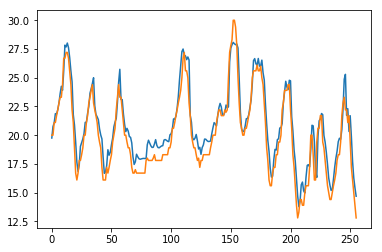

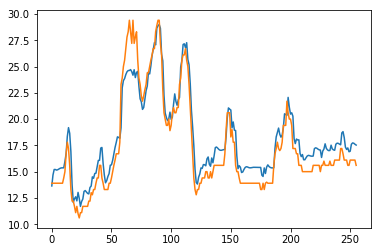

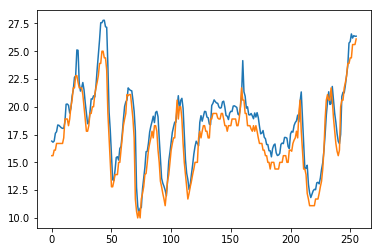

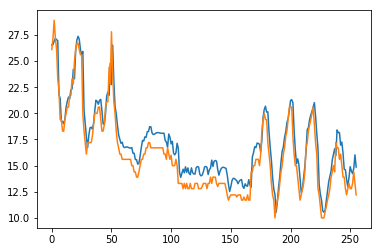

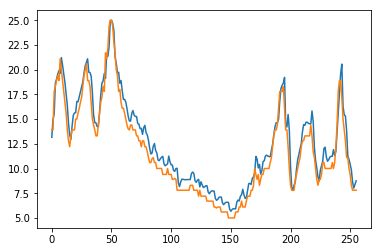

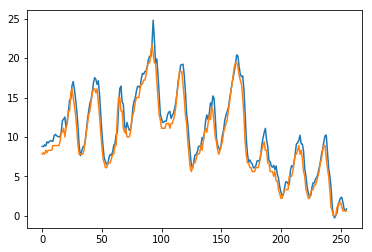

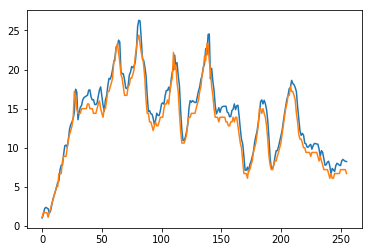

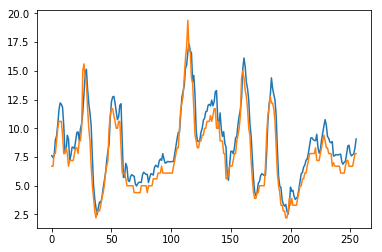

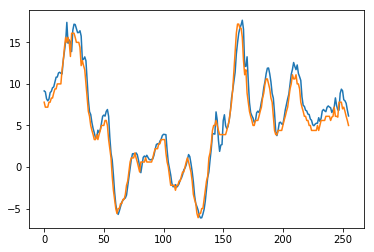

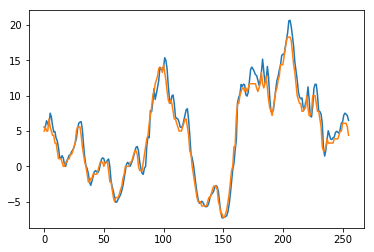

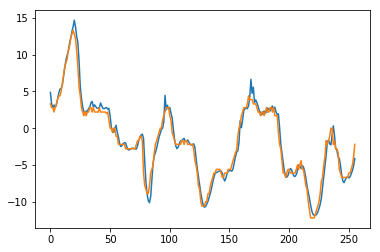

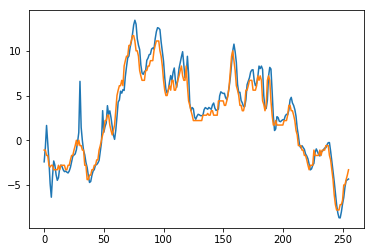

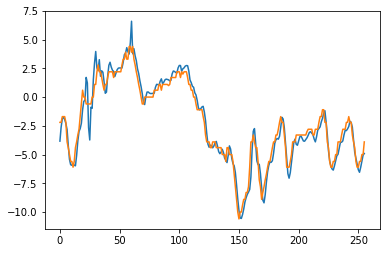

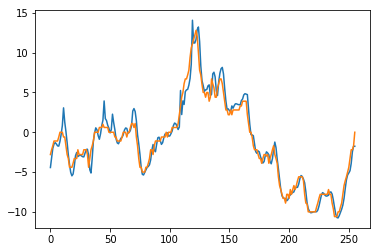

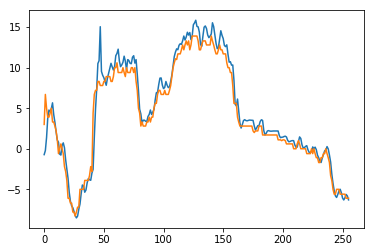

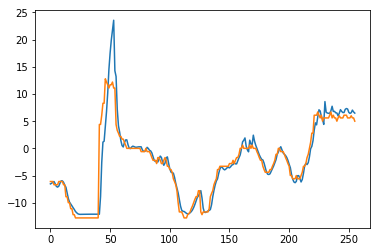

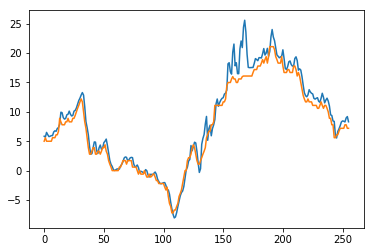

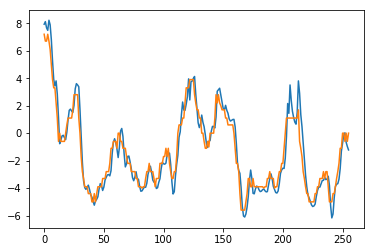

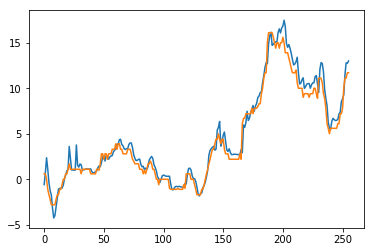

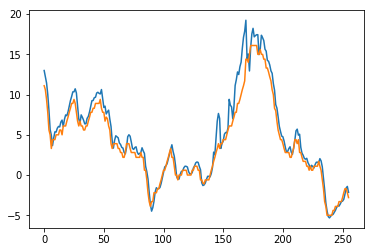

In [77]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_num = 256

for i in range(steps_test-1):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels_arr[start_idx:end_idx])
    plt.draw()
    plt.savefig('./time_series/range_%i.png' % i)

In [81]:
print 'traninig data point %i' % len(df1)
print 'testing data point %i' % len(df_test)
print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)

traninig data point 22081
testing data point 5518
the mean squared error for test data are 1.749745 


In [ ]:
np.random.rand

In [ ]:
batch_size = 256
INPUT_DIM = 6 # six input feature
time_step = 48 # 12 consecutive data to predict next one
n_hidden = 64 # encoder dim
d_hidden = 64 # decoder dim
## o_hidden = 16 default

current_episode = 0
total_episodes = 220
steps = int(len(df1)/batch_size)

tf.reset_default_graph()

model = ts_prediction(input_dim = 6, time_step = time_step, n_hidden= n_hidden, d_hidden = d_hidden, batch_size = batch_size)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

while current_episode<=total_episodes:
    cumulative_loss = 0.0
    
    for t in range(steps):
        ## shuffle the batch
        #index = range(x.shape[0])
        #np.random.shuffle(index)
        x,y,labels = get_batch(df1,batch_size = batch_size, T = time_step, step = t)
        train_seq_len =  np.ones(batch_size) * time_step
        feed = {model.input_x: x, 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels}
        loss_1, adversarial_gradients = sess.run([model.loss_1,model.adversarial_gradient],feed_dict = feed)
        
        #epsilon = np.random.uniform(0,0.5,1)
        
        feed = {model.input_x: x + epsilon*adversarial_gradients[0], 
                model.seq_len: train_seq_len,
                model.input_y: y,
                model.label: labels,
                model.original_loss: loss_1}
        loss, _ = sess.run([model.loss, model.train_op], feed_dict = feed)
        
        cumulative_loss += loss
        if t%10==0:
            print "current_episode %i, steps %i, losses are %f" % ( current_episode, t, cumulative_loss)
            cumulative_loss = 0.0
    current_episode+=1



current_episode 0, steps 0, losses are 1251.223999
current_episode 0, steps 10, losses are 11648.365784
current_episode 0, steps 20, losses are 2362.368996
current_episode 0, steps 30, losses are 2069.183990
current_episode 0, steps 40, losses are 9305.067200
current_episode 0, steps 50, losses are 7065.613251
current_episode 0, steps 60, losses are 1106.983711
current_episode 1, steps 0, losses are 942.581421
current_episode 1, steps 10, losses are 8468.940491
current_episode 1, steps 20, losses are 1283.596638
current_episode 1, steps 30, losses are 1124.419426
current_episode 1, steps 40, losses are 6207.394867
current_episode 1, steps 50, losses are 4430.795837
current_episode 1, steps 60, losses are 1564.311630
current_episode 2, steps 0, losses are 641.559509
current_episode 2, steps 10, losses are 5763.437378
current_episode 2, steps 20, losses are 945.023430
current_episode 2, steps 30, losses are 925.926506
current_episode 2, steps 40, losses are 4439.184669
current_episode 2,

current_episode 22, steps 60, losses are 49.943655
current_episode 23, steps 0, losses are 7.331652
current_episode 23, steps 10, losses are 81.888178
current_episode 23, steps 20, losses are 35.658302
current_episode 23, steps 30, losses are 20.897641
current_episode 23, steps 40, losses are 69.724069
current_episode 23, steps 50, losses are 34.439457
current_episode 23, steps 60, losses are 46.818624
current_episode 24, steps 0, losses are 5.969974
current_episode 24, steps 10, losses are 72.987708
current_episode 24, steps 20, losses are 32.698376
current_episode 24, steps 30, losses are 18.776233
current_episode 24, steps 40, losses are 60.882547
current_episode 24, steps 50, losses are 31.918131
current_episode 24, steps 60, losses are 43.577973
current_episode 25, steps 0, losses are 5.585443
current_episode 25, steps 10, losses are 65.625699
current_episode 25, steps 20, losses are 30.665878
current_episode 25, steps 30, losses are 17.416793
current_episode 25, steps 40, losses 

current_episode 46, steps 0, losses are 1.962365
current_episode 46, steps 10, losses are 24.998812
current_episode 46, steps 20, losses are 17.153186
current_episode 46, steps 30, losses are 9.804166
current_episode 46, steps 40, losses are 19.346571
current_episode 46, steps 50, losses are 15.752439
current_episode 46, steps 60, losses are 14.191716
current_episode 47, steps 0, losses are 1.937072
current_episode 47, steps 10, losses are 24.464949
current_episode 47, steps 20, losses are 16.866002
current_episode 47, steps 30, losses are 9.670334
current_episode 47, steps 40, losses are 18.865354
current_episode 47, steps 50, losses are 15.605317
current_episode 47, steps 60, losses are 13.795736
current_episode 48, steps 0, losses are 1.902231
current_episode 48, steps 10, losses are 23.922791
current_episode 48, steps 20, losses are 16.580101
current_episode 48, steps 30, losses are 9.537191
current_episode 48, steps 40, losses are 18.389317
current_episode 48, steps 50, losses are

In [11]:
steps_test = int(len(df_test)/batch_size)
test_loss = 0.0
y_hat_arr = np.empty(shape = [0])
y_labels_arr = np.empty(shape = [0])

for t in range(steps_test-1):

    x_test,y_test,labels_test = get_batch(df_test,batch_size = batch_size, T = time_step, step = t, train = False)   
    y_hat = model.predict(x_test,y_test,sess) 
    y_hat_arr = np.concatenate([y_hat_arr,np.array(y_hat)])
    y_labels_arr = np.concatenate([y_labels_arr,np.array(labels_test)])
    test_loss += np.mean(np.square(y_hat - labels_test))

print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)

the mean squared error for test data are 1.008957 


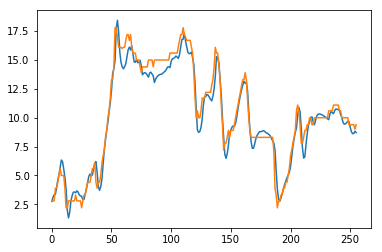

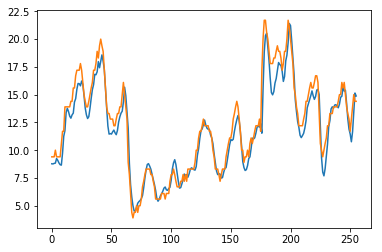

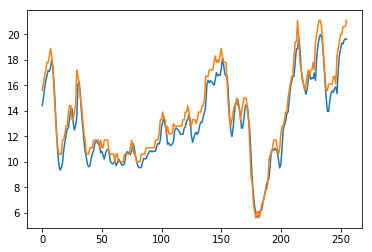

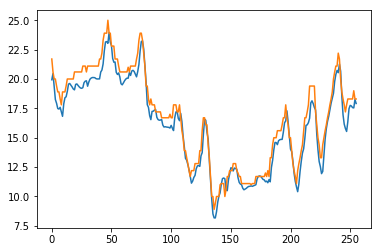

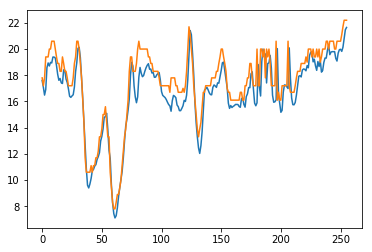

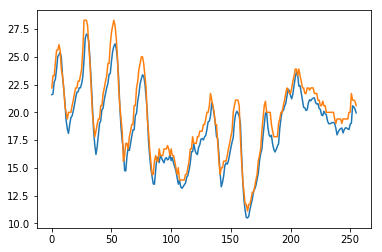

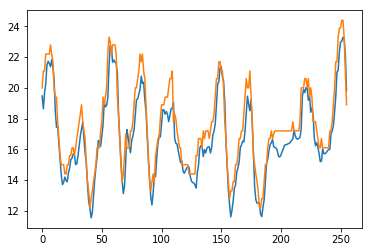

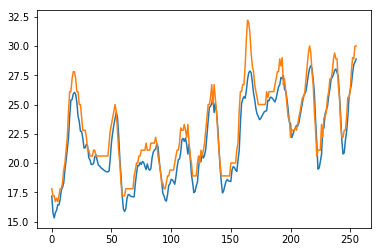

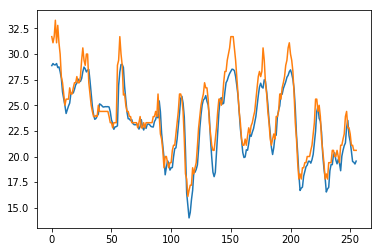

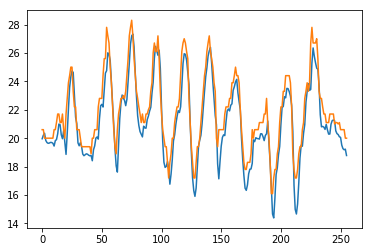

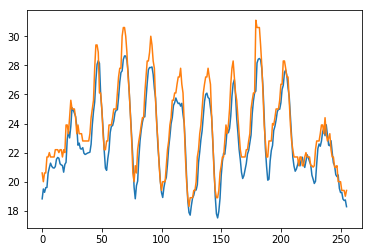

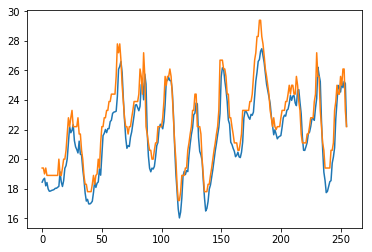

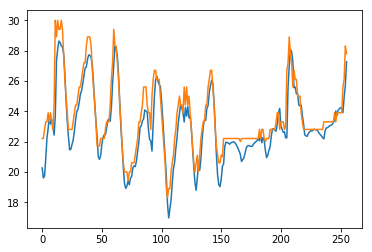

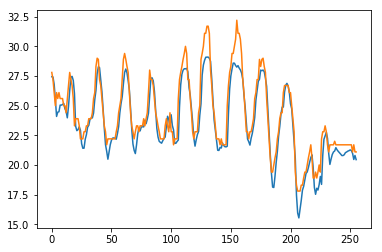

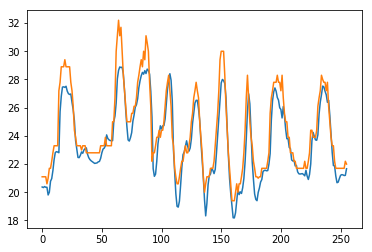

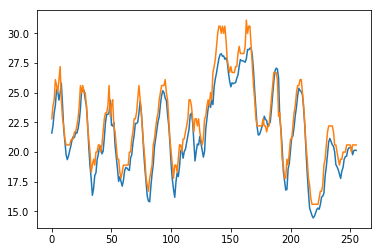

In [14]:
# from matplotlib import pyplot as plt
# %matplotlib inline

# plot_num = 256

# for i in range(steps_test-1):
#     start_idx = i*plot_num
#     end_idx = (i+1)*plot_num
#     plt.figure()
#     plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
#     plt.plot(range(plot_num),y_labels_arr[start_idx:end_idx])
#     plt.draw()
#     plt.savefig('./adversarial_training1/range_%i.png' % i)

In [ ]:
# 200 episode

In [16]:
steps_test = int(len(df_test)/batch_size)
test_loss = 0.0
y_hat_arr = np.empty(shape = [0])
y_labels_arr = np.empty(shape = [0])

for t in range(steps_test-1):

    x_test,y_test,labels_test = get_batch(df_test,batch_size = batch_size, T = time_step, step = t, train = False)   
    y_hat = model.predict(x_test,y_test,sess) 
    y_hat_arr = np.concatenate([y_hat_arr,np.array(y_hat)])
    y_labels_arr = np.concatenate([y_labels_arr,np.array(labels_test)])
    test_loss += np.mean(np.square(y_hat - labels_test))

print "the mean squared error for test data are %f " % (test_loss*1.0/steps_test)

the mean squared error for test data are 0.748558 


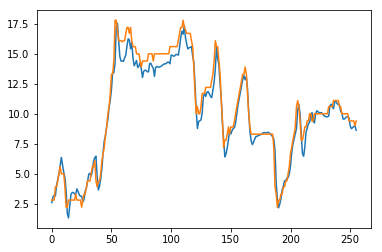

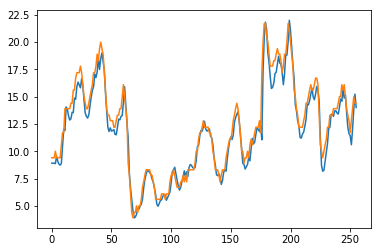

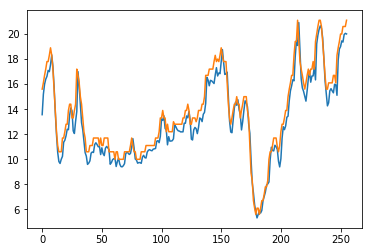

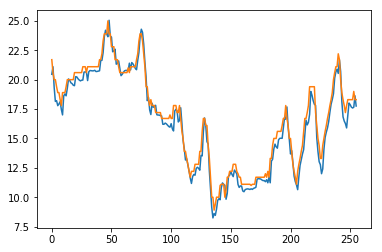

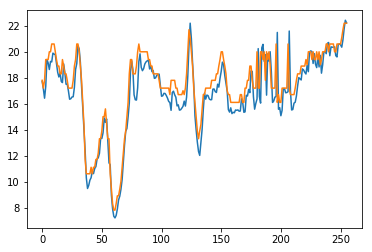

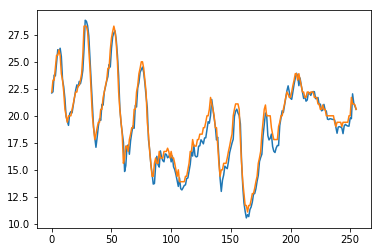

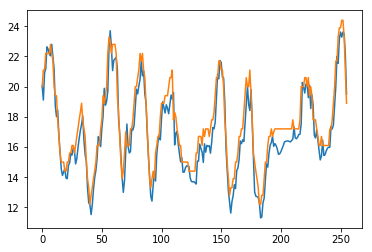

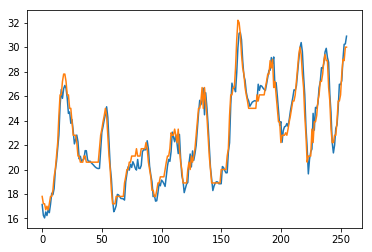

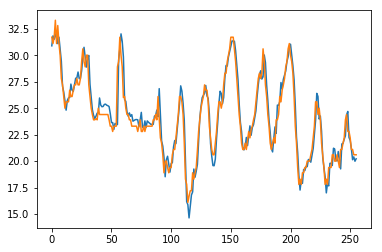

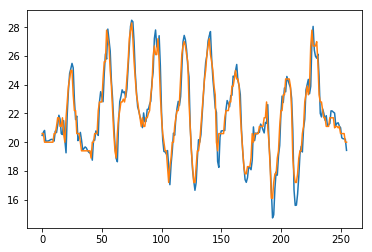

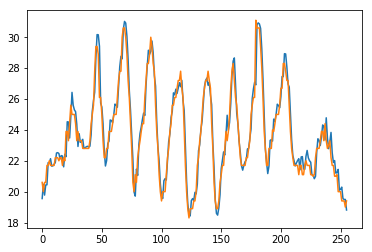

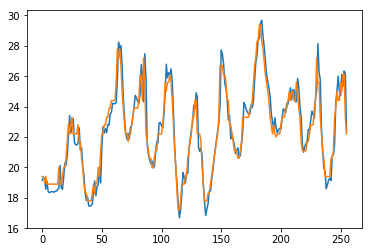

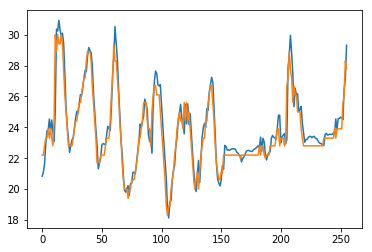

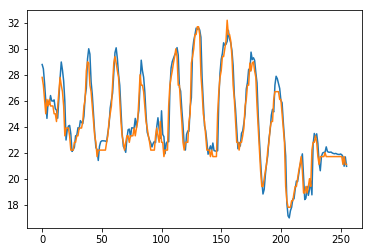

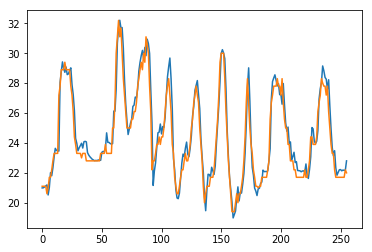

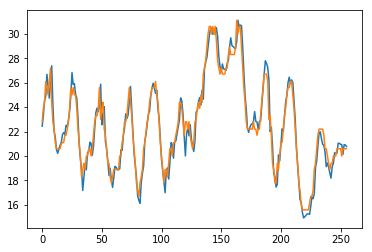

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

plot_num = 256

for i in range(steps_test-1):
    start_idx = i*plot_num
    end_idx = (i+1)*plot_num
    plt.figure()
    plt.plot(range(plot_num),y_hat_arr[start_idx:end_idx])
    plt.plot(range(plot_num),y_labels_arr[start_idx:end_idx])
    plt.draw()
    plt.savefig('./adversarial_training1/range_%i.png' % i)